In [197]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics

## Action Data

In [2]:
df_hit = pd.read_csv('/Users/sergey/Downloads/ga_hits-001.csv')
df_hit.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


In [3]:
df_hit.shape

(15726470, 11)

### Data Preparation

In [4]:
df_hit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


#### Check dublicated records

In [5]:
#show dublicates
df_hit[df_hit.duplicated()]

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value


In [6]:
#=> no dublicated records

#### Check data fullness

In [7]:
!pip install missingno

In [8]:
import missingno as msno

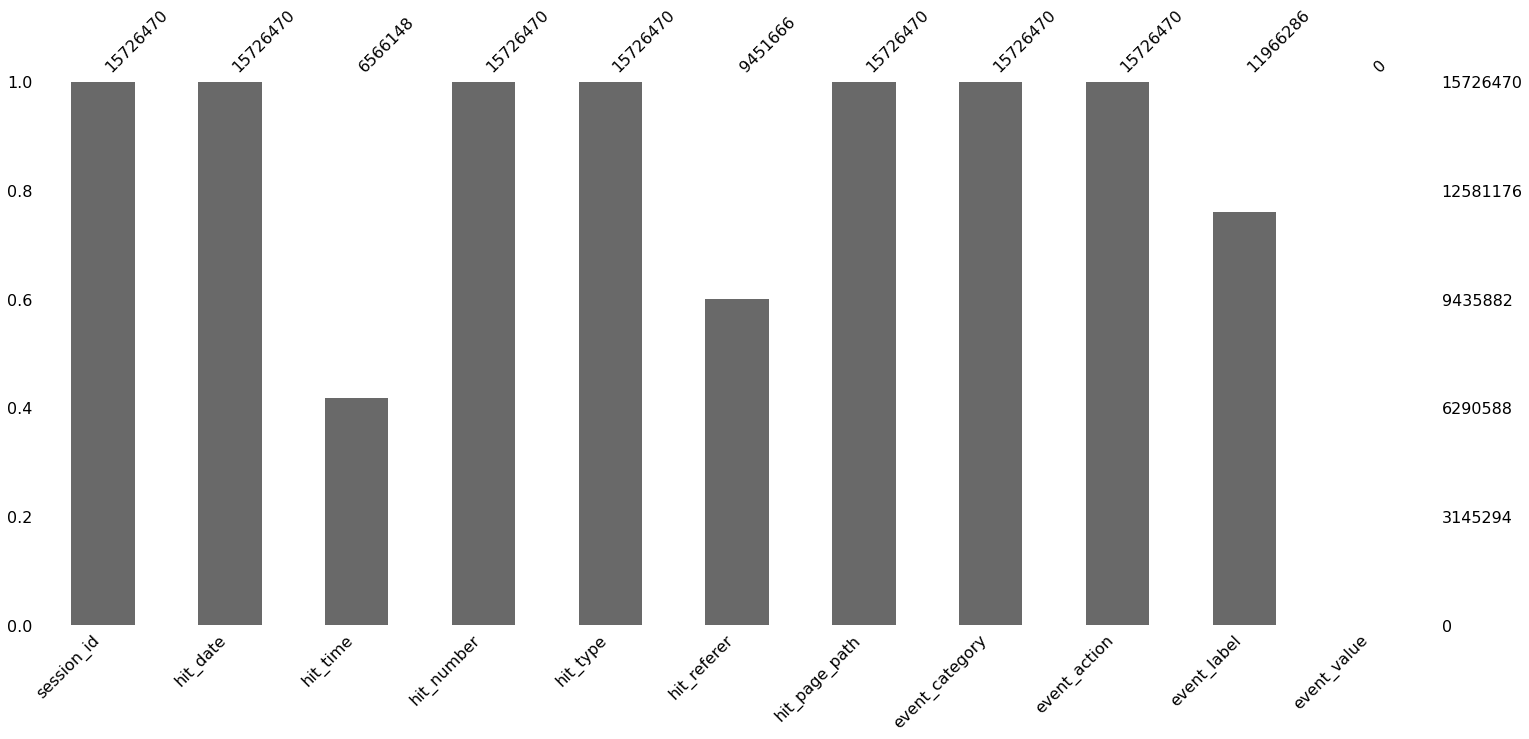

In [9]:
msno.bar(df_hit);

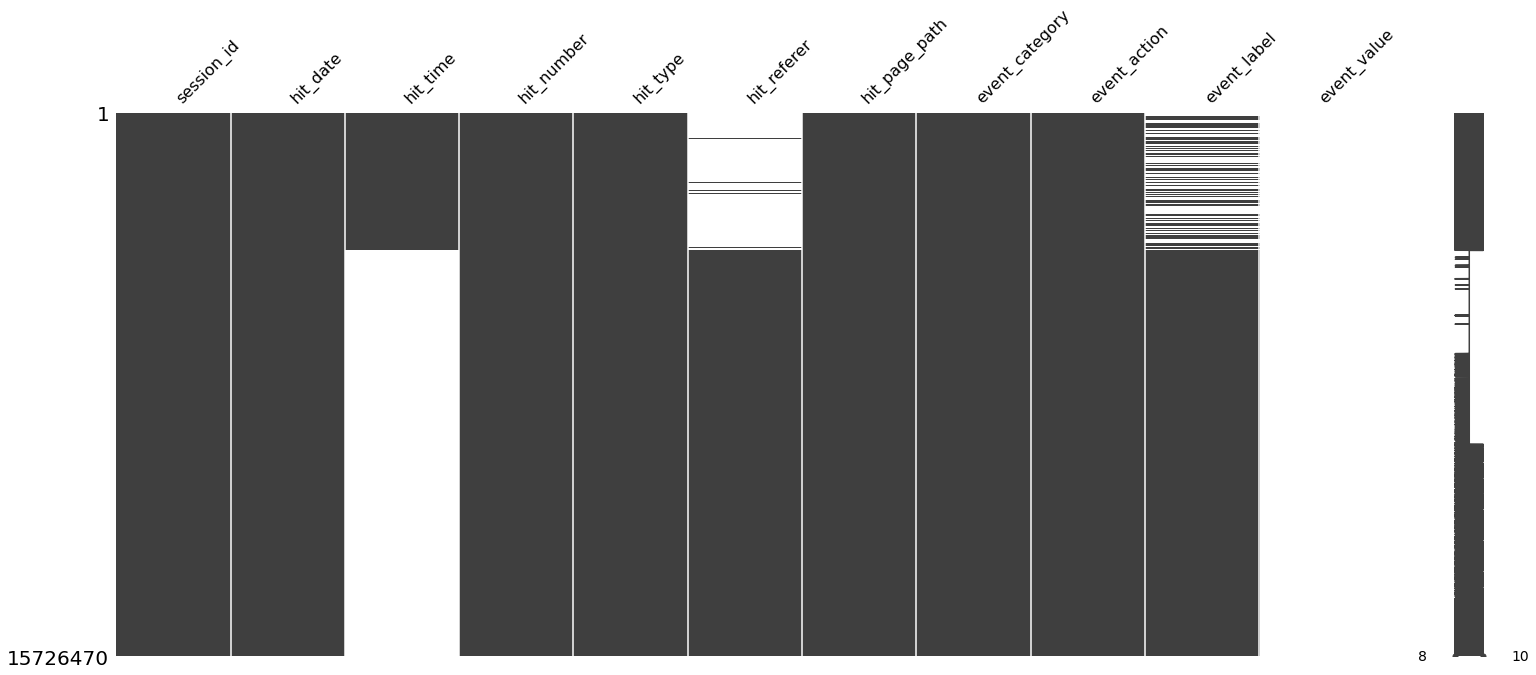

In [10]:
msno.matrix(df_hit);

In [11]:
#event_value is empty, seems to be error data

In [12]:
# function to show missed values per columns 

def missed_values(df):
    missed_values = ((df.isna().sum() / len(df)) * 100).sort_values(ascending=False)
    print('% missed records in dataset: ') 
    print(missed_values)

In [13]:
missed_values(df_hit)

% missed records in dataset: 
event_value       100.000000
hit_time           58.247795
hit_referer        39.899634
event_label        23.909905
session_id          0.000000
hit_date            0.000000
hit_number          0.000000
hit_type            0.000000
hit_page_path       0.000000
event_category      0.000000
event_action        0.000000
dtype: float64


In [14]:
# event_action s/b deleted

In [15]:
df_hit_prep = df_hit.copy()

In [16]:
df_hit_prep = df_hit_prep.drop(columns='event_value')

In [17]:
# function to show full records from dataset
def print_useful_rows_info(df):
    print('Full records:', 
          len(df.dropna()),'from', df.shape[0])
    print('dataset is fully filled on :', 
          round((len(df.dropna()) / len(df) * 100), 2), '%')

In [18]:
print_useful_rows_info(df_hit_prep)

Full records: 118953 from 15726470
dataset is fully filled on : 0.76 %


In [19]:
# from bar plot, matrix image and missed record calculation function columns 
# hit_time, hit_referer and event_label have more than 20% missed records, so s/b romoved from research

In [20]:
df_hit[['session_id','hit_date','hit_number','hit_type','hit_page_path','event_category','event_action']].describe(include='all')

,session_id,hit_date,hit_number,hit_type,hit_page_path,event_category,event_action
count,15726470,15726470,1.572647e+07,15726470,15726470,15726470,15726470
unique,1734610,226,NaN,1,342715,52,230
top,5442565791571325612.1632449195.1632449195,2021-05-24,NaN,event,podpiska.sberauto.com/,card_web,view_card
freq,768,513035,NaN,15726470,2793639,7456998,3558985
mean,NaN,NaN,2.356715e+01,NaN,NaN,NaN,NaN
std,NaN,NaN,2.887713e+01,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN
25%,NaN,NaN,7.000000e+00,NaN,NaN,NaN,NaN
50%,NaN,NaN,1.500000e+01,NaN,NaN,NaN,NaN
75%,NaN,NaN,2.900000e+01,NaN,NaN,NaN,NaN


In [21]:
#hit_type has all values='event', it's not informal and s/b deleted from dataframe

In [22]:
hit_columns_to_drop = ['hit_time',
                       'hit_referer',
                       'event_label',
                       'hit_type']

In [23]:
df_hit_prep = df_hit_prep.drop(columns=hit_columns_to_drop)

In [24]:
print_useful_rows_info(df_hit_prep)

Full records: 15726470 from 15726470
dataset is fully filled on : 100.0 %


In [25]:
#save cleaned dataset
df_hit_prep.to_csv('/Users/sergey/Downloads/diploma/df_hit_prep.csv', index=False)

In [26]:
#dict for keeping useful user actions 
useful_action_dict = {'sub_car_claim_click': 0,
                    'sub_car_claim_submit_click': 0,
                    'sub_open_dialog_click': 0, 
                    'sub_custom_question_submit_click': 0,
                    'sub_call_number_click': 0, 
                    'sub_callback_submit_click': 0, 
                    'sub_submit_success': 0,
                    'sub_car_request_submit_click': 0}

In [27]:
#save session_id of users who done useful actions
data_session = df_hit_prep[(df_hit_prep.event_action == 'sub_car_claim_click') |
                          (df_hit_prep.event_action == 'sub_car_claim_submit_click')|
                          (df_hit_prep.event_action == 'sub_open_dialog_click')|
                          (df_hit_prep.event_action == 'sub_custom_question_submit_click')|
                          (df_hit_prep.event_action == 'sub_call_number_click')|
                          (df_hit_prep.event_action == 'sub_callback_submit_click')|
                          (df_hit_prep.event_action == 'sub_submit_success')|
                          (df_hit_prep.event_action == 'sub_car_request_submit_click')]['session_id']

In [28]:
data_session.describe()

count                                        104908
unique                                        50760
top       7140505447604038223.1630415440.1630415440
freq                                            474
Name: session_id, dtype: object

In [29]:
data_session.to_csv('/Users/sergey/Downloads/diploma/data_session.csv', index=False)

## Client data 

In [30]:
df_ses = pd.read_csv('/Users/sergey/Downloads/ga_sessions.csv')
df_ses.head(10)

/Users/sergey/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
5,9055447192389856083.1622453074.1622453074,2108385598.162245,2021-05-31,12:00:00,1,kjsLglQLzykiRbcDiGcD,organic,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,375x812,Safari,Russia,Saint Petersburg
6,9055455318486370642.1640843788.1640843788,2108387490.164084,2021-12-30,08:56:28,1,TxKUcPpthBDPieTGmVhx,cpc,FTjNLDyTrXaWYgZymFkV,LcGIUNPUAmXtQJaDfFBR,PwscUHjoUJDrtfWESIHj,tablet,Android,Lenovo,NaN,602x1029,YaBrowser,Russia,Saint Petersburg
7,9055461992850812764.1626107740.1626107740,2108389044.162611,2021-07-12,19:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Samsung,NaN,360x640,Chrome,Russia,Saint Petersburg
8,9055462349345527315.1638536723.1638536723,2108389127.163854,2021-12-03,16:05:23,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,390x844,Safari,Russia,Moscow
9,9055466554104774132.1624800757.1624800757,2108390106.16248,2021-06-27,16:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Samsung,NaN,412x915,Chrome,Russia,Moscow


In [31]:
df_ses['client_id'] = df_ses['client_id'].astype(str)

In [32]:
df_ses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
dtypes: int64(1), object(17)
memory usage: 255.4+ MB


In [33]:
df_ses.shape

(1860042, 18)

### Data Preparation

#### check dublicated records

In [34]:
#show dublicates
df_ses[df_ses.duplicated()]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city


In [35]:
#=> no dublicated records

#### check data fullness

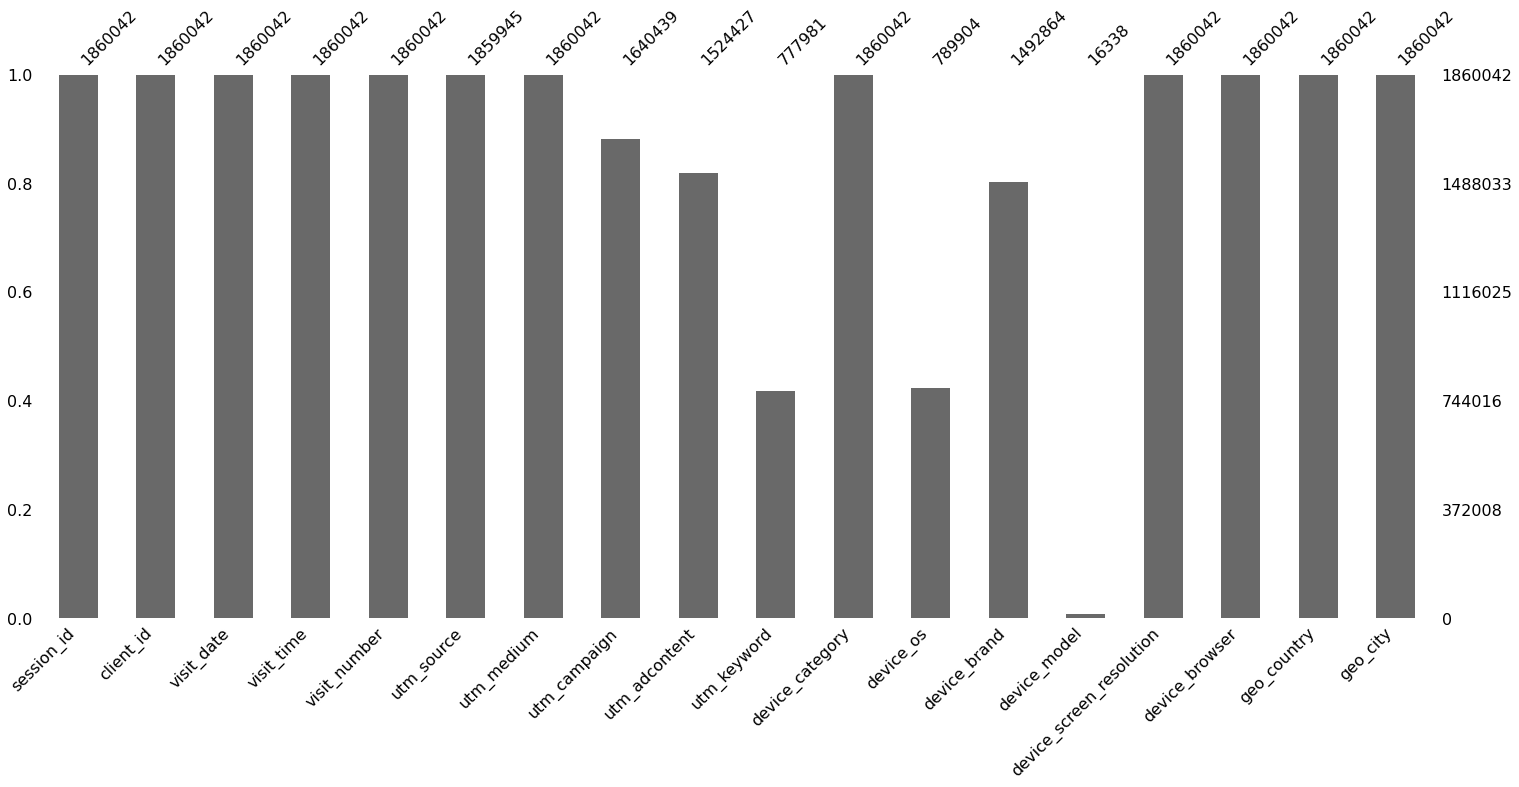

In [36]:
msno.bar(df_ses);

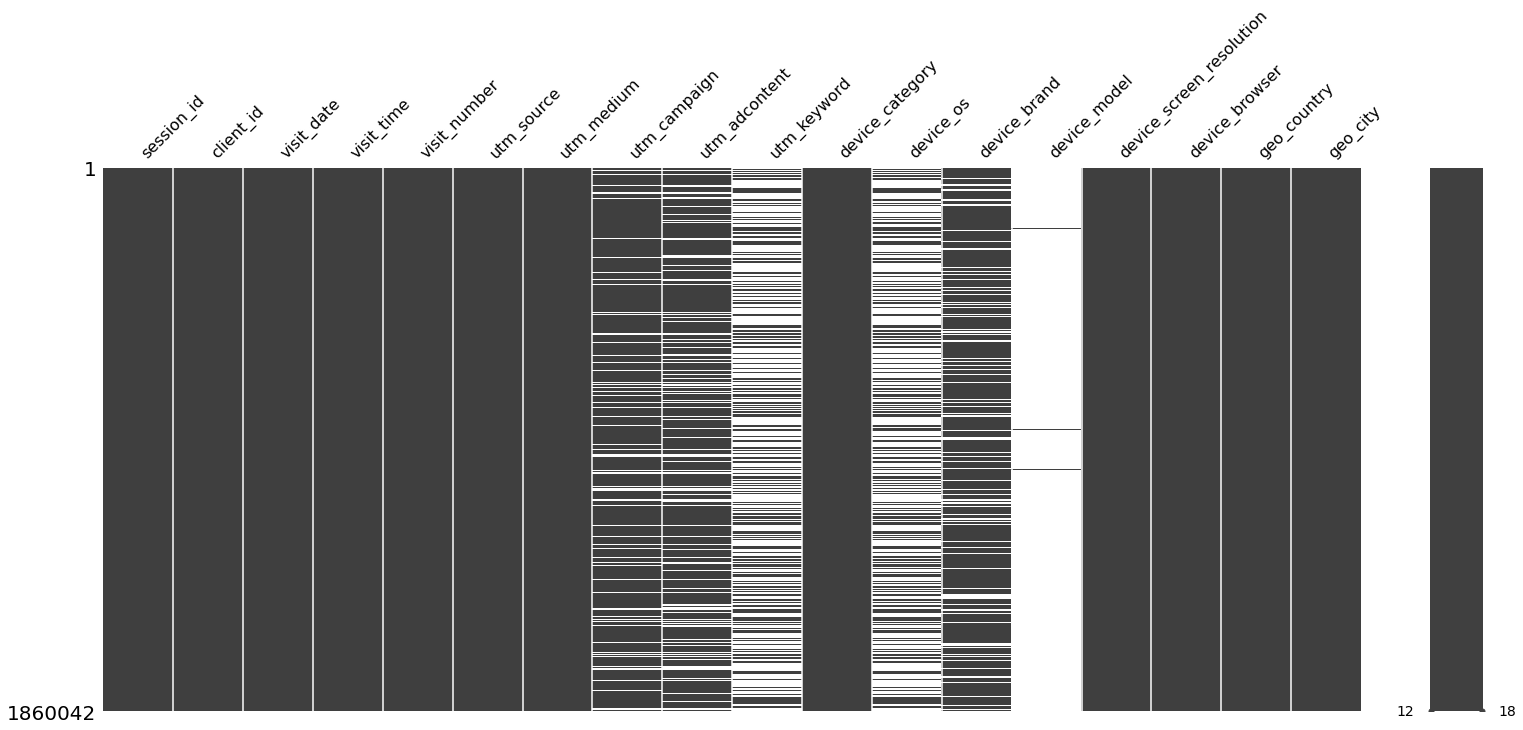

In [37]:
msno.matrix(df_ses);

In [38]:
#bar and matrix show device_model is almost empty, so it s/b deleted 

In [39]:
missed_values(df_ses)

% missed records in dataset: 
device_model                99.121633
utm_keyword                 58.174009
device_os                   57.533002
device_brand                19.740307
utm_adcontent               18.043410
utm_campaign                11.806346
utm_source                   0.005215
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
session_id                   0.000000
device_category              0.000000
client_id                    0.000000
utm_medium                   0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
geo_city                     0.000000
dtype: float64


In [40]:
#also s/b deleted columns where missed records more than 20% as utm_keyword, device_os

In [41]:
df_ses_prep = df_ses.copy()

In [42]:
ses_columns_to_drop = ['device_model', 'utm_keyword','device_os']

In [43]:
df_ses_prep = df_ses_prep.drop(columns = ses_columns_to_drop)

In [44]:
df_ses_prep.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637757,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.16368672,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Samsung,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622252,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,mobile,Xiaomi,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622252,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,mobile,Xiaomi,393x786,Chrome,Russia,Moscow


In [45]:
df_ses_prep['device_brand'].describe()

count     1492864
unique        205
top         Apple
freq       551088
Name: device_brand, dtype: object

In [46]:
df_ses_prep['device_brand'].value_counts(dropna=False)

Apple       551088
NaN         367178
Samsung     332194
Xiaomi      288367
Huawei      185853
             ...  
Vodafone         1
Wexler           1
KingSing         1
Star             1
Opera            1
Name: device_brand, Length: 206, dtype: int64

In [47]:
df_ses_prep[df_ses_prep['device_brand'].isna()]['device_category'].value_counts()

desktop    366721
mobile        298
tablet        159
Name: device_category, dtype: int64

In [48]:
df_ses_prep[df_ses_prep['device_category']=='desktop']['device_brand'].value_counts(dropna=False)

NaN          366721
Apple            72
Huawei           19
Xiaomi           10
(not set)        10
Samsung           8
Realme            5
Google            4
OPPO              4
Flexymove         3
Beelink           2
OnePlus           2
Nokia             1
Asus              1
Philips           1
Name: device_brand, dtype: int64

In [49]:
# almost all brand name for desktop is nknown (NAN or not set values)
# fill missed brand values for desktop

In [50]:
df_ses_prep.loc[(df_ses_prep['device_category']=='desktop') & ((df_ses_prep['device_brand'].isna()) |(df_ses_prep['device_brand']=='(not set)')), 'device_brand'] = 'other'

In [51]:
df_ses_prep[df_ses_prep['device_category']=='desktop']['device_brand'].value_counts(dropna=False)

other        366731
Apple            72
Huawei           19
Xiaomi           10
Samsung           8
Realme            5
Google            4
OPPO              4
Flexymove         3
Beelink           2
OnePlus           2
Nokia             1
Asus              1
Philips           1
Name: device_brand, dtype: int64

In [52]:
# fill missed brand values for mobile

In [53]:
df_ses_prep[(df_ses_prep['device_brand'].isna()) & (df_ses_prep['device_category']=='mobile')]['device_browser'].value_counts()

Chrome              250
Safari               22
Samsung Internet      9
Firefox               5
YaBrowser             5
Opera                 3
Edge                  3
UC Browser            1
Name: device_browser, dtype: int64

In [54]:
df_ses_prep.loc[(df_ses_prep['device_category']=='mobile') & (df_ses_prep['device_brand'].isna()) & (df_ses_prep['device_browser']=='Safari'), 'device_brand'] = 'Apple'

In [55]:
df_ses_prep.loc[(df_ses_prep['device_category']=='mobile') & (df_ses_prep['device_brand'].isna()) & (df_ses_prep['device_browser']=='Samsung Internet'), 'device_brand'] = 'Samsung'

In [56]:
#the last brand names for mobile c/n berestored from browser name, so let them be 'other'
df_ses_prep.loc[(df_ses_prep['device_category']=='mobile') & (df_ses_prep['device_brand'].isna()), 'device_brand'] = 'other'

In [57]:
#fill missed brand values for tablets

In [58]:
df_ses_prep[(df_ses_prep['device_brand'].isna()) & (df_ses_prep['device_category']=='tablet')]['device_browser'].value_counts(dropna=False)

Safari              117
Samsung Internet     26
Chrome               15
Opera                 1
Name: device_browser, dtype: int64

In [59]:
#fill missed brand values as 'Apple' for devices with 'Safari' browser and 'Samsung' with 'Samsung Internet', the last as 'other'
df_ses_prep.loc[(df_ses_prep['device_category']=='tablet') & (df_ses_prep['device_brand'].isna()) & (df_ses_prep['device_browser']=='Safari'), 'device_brand'] = 'Apple'
df_ses_prep.loc[(df_ses_prep['device_category']=='tablet') & (df_ses_prep['device_brand'].isna()) & (df_ses_prep['device_browser']=='Samsung Internet'), 'device_brand'] = 'Samsung'
df_ses_prep.loc[(df_ses_prep['device_category']=='tablet') & (df_ses_prep['device_brand'].isna()), 'device_brand'] = 'other'

In [60]:
df_ses_prep[df_ses_prep['device_category']=='tablet']['device_brand'].value_counts(dropna=False)

Apple           6340
Samsung         4981
Huawei          3441
Lenovo          1656
Google           713
                ... 
ZTE                1
Dragon Touch       1
Tanix              1
Nomu               1
Explay             1
Name: device_brand, Length: 74, dtype: int64

In [61]:
df_ses_prep[df_ses_prep['device_brand']=='(not set)']['device_browser'].value_counts()

Chrome                    12660
Firefox                    1711
YaBrowser                  1465
Android Webview            1049
Samsung Internet            324
Opera                       245
Opera Mini                   25
UC Browser                   15
Mozilla                      11
Safari                       10
com.vk.vkclient               8
Internet Explorer             6
Android Runtime               3
Android Browser               1
[FBAN                         1
Threads 202.0.0.23.119        1
Name: device_browser, dtype: int64

In [62]:
#fill '(not_set)' values for device brand the same way as above
df_ses_prep.loc[(df_ses_prep['device_brand']=='(not set)') & (df_ses_prep['device_browser']=='Samsung Internet'),'device_brand'] ='Samsung'
df_ses_prep.loc[(df_ses_prep['device_brand']=='(not set)') & (df_ses_prep['device_browser']=='Safari'),'device_brand'] ='Apple'
df_ses_prep.loc[df_ses_prep['device_brand']=='(not set)','device_brand'] ='other'

In [63]:
df_ses_prep['device_browser'].value_counts()

Chrome                              1013436
Safari                               478562
YaBrowser                            133311
Safari (in-app)                       69912
Android Webview                       55369
Samsung Internet                      47309
Opera                                 26817
Firefox                               16588
Edge                                  16065
UC Browser                              871
Android Runtime                         392
Mozilla Compatible Agent                362
[FBAN                                   269
Instagram 208.0.0.32.135 Android        140
Instagram 209.0.0.21.119 Android        111
MRCHROME                                 77
Android Browser                          49
Opera Mini                               45
Puffin                                   45
Internet Explorer                        36
Maxthon                                  31
Android                                  22
Instagram 216.1.0.21.137 Android

In [64]:
df_ses_prep.loc[df_ses_prep['device_browser'] =='Safari (in-app)','device_browser'] = 'Safari'

In [65]:
df_ses_prep.loc[df_ses_prep['device_browser'] =='(not set)','device_browser'] = 'other'

In [66]:
missed_values(df_ses_prep)

% missed records in dataset: 
utm_adcontent               18.043410
utm_campaign                11.806346
utm_source                   0.005215
session_id                   0.000000
client_id                    0.000000
visit_date                   0.000000
visit_time                   0.000000
visit_number                 0.000000
utm_medium                   0.000000
device_category              0.000000
device_brand                 0.000000
device_screen_resolution     0.000000
device_browser               0.000000
geo_country                  0.000000
geo_city                     0.000000
dtype: float64


In [67]:
# fill missed value for utm_adcontent

In [68]:
df_ses_prep['utm_adcontent'].describe()

count                  1524427
unique                     286
top       JNHcPlZPxEMWDnRiyoBf
freq                   1006599
Name: utm_adcontent, dtype: object

In [69]:
df_ses_prep['utm_adcontent'].value_counts(dropna=False)

JNHcPlZPxEMWDnRiyoBf    1006599
NaN                      335615
vCIpmpaGBnIQhyYNkXqp     181048
xhoenQgDQsgfEPYNPwKO     113072
PkybGvWbaqORmxjNunqZ      60316
                         ...   
vXARZToVDdvNhALiQtvl          1
ryswqHdLvbezpDLjokYF          1
gQEnaeQmOHisHSTEyzhp          1
PlanrlymnpCeYvUrUTVJ          1
oJivRDNIrrOckRBIKOtG          1
Name: utm_adcontent, Length: 287, dtype: int64

In [70]:
df_ses_prep.loc[df_ses_prep['utm_adcontent'].isna(), 'utm_adcontent'] = 'other'

In [71]:
# fill missed value for utm_campaign

In [72]:
df_ses_prep['utm_campaign'].value_counts(dropna=False)

LTuZkdKfxRGVceoWkVyg    463481
LEoPHuyFvzoNfnzGgfcd    324044
FTjNLDyTrXaWYgZymFkV    247360
NaN                     219603
gecBYcKZCPMcVYdSSzKP    134042
                         ...  
RkpOyeEPgcMBSDuHLQcj         1
pcvPxfVFaAmhwFmvIeYd         1
qPDTdivQVeflLjTYIJnG         1
MHdHrBKQwbDaRalwnlJq         1
cXxuwXPoQCvAXPHpFcZl         1
Name: utm_campaign, Length: 413, dtype: int64

In [73]:
df_ses_prep.loc[df_ses_prep['utm_campaign'].isna(), 'utm_campaign'] = 'other'

In [74]:
# fill missed value for utm_source

In [75]:
df_ses_prep['utm_source'].describe()

count                  1859945
unique                     293
top       ZpYIoDJMcFzVoPFsHGJL
freq                    578290
Name: utm_source, dtype: object

In [76]:
df_ses_prep['utm_source'].value_counts(dropna=False)

ZpYIoDJMcFzVoPFsHGJL    578290
fDLlAcSmythWSCVMvqvL    300575
kjsLglQLzykiRbcDiGcD    266354
MvfHsxITijuriZxsqZqt    186199
BHcvLfOaCWvWTykYqHVe    116320
                         ...  
GYkgJdhSxirUFPHFiYSe         1
WRHPhoRKhKxaenRCLBfo         1
tjKUGseGMhkLEzdCqBRx         1
wpmatvDuiMutnvmNVPJo         1
BellrslNBZQZaIxVFGXJ         1
Name: utm_source, Length: 294, dtype: int64

In [77]:
df_ses_prep.loc[df_ses_prep['utm_source'].isna(), 'utm_source'] = 'other'

In [78]:
missed_values(df_ses_prep)

% missed records in dataset: 
session_id                  0.0
client_id                   0.0
visit_date                  0.0
visit_time                  0.0
visit_number                0.0
utm_source                  0.0
utm_medium                  0.0
utm_campaign                0.0
utm_adcontent               0.0
device_category             0.0
device_brand                0.0
device_screen_resolution    0.0
device_browser              0.0
geo_country                 0.0
geo_city                    0.0
dtype: float64


In [79]:
df_ses_prep.to_csv('/Users/sergey/Downloads/diploma/df_ses_prep.csv', index=False)

## Merged data

In [80]:
data_session = pd.read_csv('/Users/sergey/Downloads/diploma/data_session.csv')

### Data Preparation

#### Check dublicated records

In [81]:
len(data_session[data_session.duplicated()])

54148

In [82]:
data_session=data_session.drop_duplicates()

#### Check merged data

In [83]:
data_session.head()

,session_id
0,2744563715298057088.1640258436.1640258436
1,3087297479839089634.1640268774.1640268774
2,3156966333326004302.1640206419.1640206800
3,3750243879753098158.1640272208.1640272208
4,7518333712042258254.1640258901.1640258901


In [84]:
data_session.loc[:,'useful_action'] = 1

In [85]:
data_session.head()

,session_id,useful_action
0,2744563715298057088.1640258436.1640258436,1
1,3087297479839089634.1640268774.1640268774,1
2,3156966333326004302.1640206419.1640206800,1
3,3750243879753098158.1640272208.1640272208,1
4,7518333712042258254.1640258901.1640258901,1


In [86]:
df_merge = pd.merge(left=df_ses_prep, right=data_session, on='session_id', how='left')

In [87]:
df_merge.shape

(1860042, 16)

In [88]:
df_merge['useful_action'].value_counts(dropna=False)

NaN    1809728
1.0      50314
Name: useful_action, dtype: int64

In [89]:
df_merge['useful_action'] = df_merge['useful_action'].fillna(0)

In [90]:
df_merge['useful_action'].value_counts(dropna=False)

0.0    1809728
1.0      50314
Name: useful_action, dtype: int64

In [91]:
df_merge.to_csv('/Users/sergey/Downloads/diploma/df_merge.csv', index=False)

### Feature Engineering

In [92]:
#visit number distribution

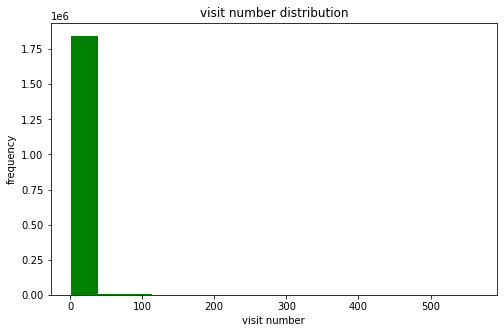

In [93]:
plt.figure(figsize=(8,5))
plt.hist(df_merge['visit_number'], bins = 15, color ='green')
plt.xlabel('visit number')
plt.ylabel('frequency')
plt.title('visit number distribution');

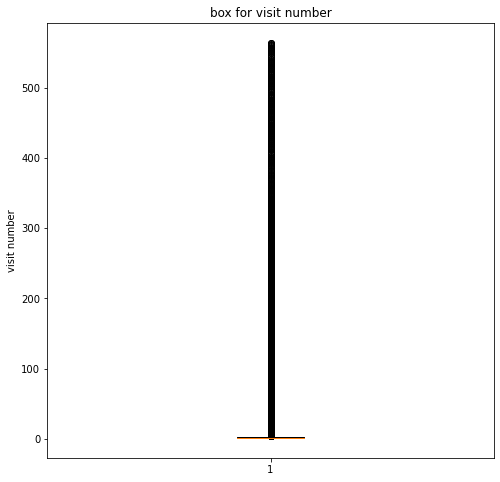

In [94]:
from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots(figsize=(8, 8))
ax.boxplot(df_merge['visit_number'])
ax.set_ylabel('visit number')
ax.set_title('box for visit number')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

In [95]:
#s/b anomaly values

In [96]:
df_merge['visit_number'].describe().apply(lambda x: f"{x:0.3f}")

count    1860042.000
mean           2.713
std           11.829
min            1.000
25%            1.000
50%            1.000
75%            2.000
max          564.000
Name: visit_number, dtype: object

In [97]:
df_merge['visit_number'].value_counts()[:10]

1     1376349
2      235656
3       81068
4       41666
5       24271
6       16473
7       11640
8        8735
9        6692
10       5413
Name: visit_number, dtype: int64

In [98]:
max_cutoff_visit = round(df_merge['visit_number'].mean() + df_merge['visit_number'].std(),0)
max_cutoff_visit

15.0

In [99]:
print('out of',round(len(df_merge[df_merge['visit_number'] > max_cutoff_visit])/len(df_merge),3)*100,' % from all visit_number values')

out of 1.9  % from all visit_number values


In [100]:
df_merge.loc[df_merge['visit_number']>15,'visit_number'] = 15

In [101]:
df_merge['visit_number'].describe().apply(lambda x: f"{x:0.3f}")

count    1860042.000
mean           1.875
std            2.464
min            1.000
25%            1.000
50%            1.000
75%            2.000
max           15.000
Name: visit_number, dtype: object

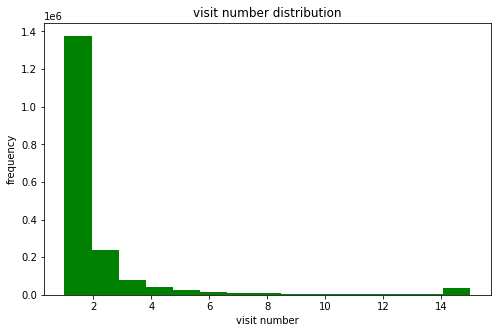

In [102]:
plt.figure(figsize=(8,5))
plt.hist(df_merge['visit_number'], bins = 15, color ='green')
plt.xlabel('visit number')
plt.ylabel('frequency')
plt.title('visit number distribution');

In [103]:
#gerenate time action from visit_time

In [104]:
df_merge['time_action'] = df_merge['visit_time'].apply(lambda x: x.split(':')[0])

In [105]:
sorted_time_actions = sorted(df_merge['time_action'])

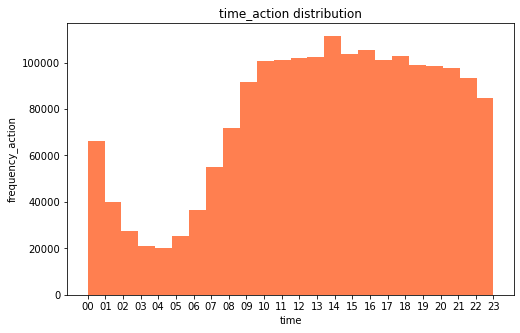

In [106]:
plt.figure(figsize=(8,5))
plt.hist(sorted_time_actions, bins = 24, color ='coral')
plt.xlabel('time')
plt.ylabel('frequency_action')
plt.title('time_action distribution');

In [107]:
# new feature - month from visit date

In [109]:
df_merge['visit_date'] = pd.to_datetime(df_merge['visit_date'], utc = True)

df_merge['visit_date'].dtype

datetime64[ns, UTC]

In [110]:
df_merge['month'] = pd.DatetimeIndex(df_merge['visit_date']).month

In [111]:
df_merge['month'].unique()

array([11, 12,  5,  7,  6,  8, 10,  9])

In [112]:
df_merge['month'].value_counts()

12    399102
11    297769
10    281622
9     257478
7     185244
6     166470
8     164155
5     108202
Name: month, dtype: int64

In [113]:
# new feature - day of week from visit_date

In [114]:
df_merge['weekday'] = df_merge['visit_date'].dt.weekday
df_merge['weekday'].unique()

array([2, 6, 1, 5, 0, 3, 4])

In [115]:
df_merge['weekday'].value_counts()

1    305130
0    300906
3    274462
4    268819
2    258616
5    226397
6    225712
Name: weekday, dtype: int64

In [117]:
#new feache - diagonal

In [118]:
df_merge['device_screen_resolution'].describe()

count     1860042
unique       5039
top       414x896
freq       169090
Name: device_screen_resolution, dtype: object

In [119]:
df_merge['device_screen_resolution'].value_counts()[:20]

414x896      169090
1920x1080    125768
375x812      117944
393x851      115454
375x667       93341
360x780       92182
360x800       80547
412x915       74744
360x640       70588
390x844       60827
393x873       52056
360x720       50603
360x760       50467
412x892       43944
428x926       40690
1536x864      37287
1366x768      34102
414x736       32631
1440x900      31036
412x846       25121
Name: device_screen_resolution, dtype: int64

In [120]:
len(df_merge[df_merge['device_screen_resolution']=='(not set)'])

8

In [121]:
df_merge[df_merge['device_screen_resolution']=='(not set)']['device_category'].unique()

array(['mobile'], dtype=object)

In [122]:
df_merge[df_merge['device_category']=='mobile']['device_screen_resolution'].value_counts()

414x896     168679
375x812     117643
393x851     114531
375x667      92206
360x780      92061
             ...  
291x568          1
459x1102         1
375x731          1
309x857          1
464x1123         1
Name: device_screen_resolution, Length: 3309, dtype: int64

In [123]:
#fill (not set) resolution with top value among mobiles
df_merge.loc[df_merge['device_screen_resolution']=='(not set)','device_screen_resolution']='414x896'

In [124]:
df_merge['device_side_dimencions'] = df_merge['device_screen_resolution'].apply(lambda x: pd.to_numeric(x.split('x')))

In [125]:
df_merge['diagonal'] = df_merge['device_side_dimencions'].apply(lambda x: round((x[0]*x[0] + x[1]*x[1])**0.5,0))
df_merge['diagonal'] = df_merge['diagonal'].astype(int) 

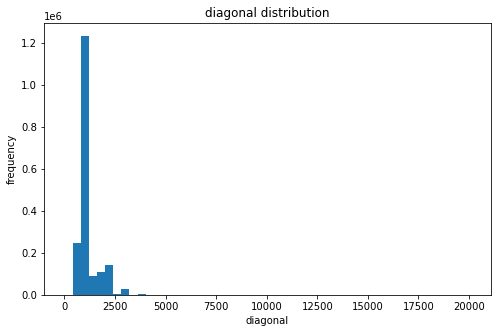

In [126]:
plt.figure(figsize=(8,5))
plt.hist(df_merge['diagonal'], bins = 50)
plt.xlabel('diagonal')
plt.ylabel('frequency')
plt.title('diagonal distribution');

In [127]:
columns_to_drop=['session_id','client_id','visit_time','device_side_dimencions','device_screen_resolution']
df_merge = df_merge.drop(columns=columns_to_drop)
df_merge.head()

,visit_date,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_browser,geo_country,geo_city,useful_action,time_action,month,weekday,diagonal
0,2021-11-24 00:00:00+00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,Chrome,Russia,Zlatoust,0.0,14,11,2,805
1,2021-11-14 00:00:00+00:00,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Samsung,Samsung Internet,Russia,Moscow,0.0,08,11,6,937
2,2021-12-28 00:00:00+00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,Chrome,Russia,Krasnoyarsk,0.0,02,12,1,805
3,2021-05-29 00:00:00+00:00,1,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,mobile,Xiaomi,Chrome,Russia,Moscow,0.0,05,5,5,879
4,2021-05-29 00:00:00+00:00,2,kjsLglQLzykiRbcDiGcD,cpc,other,other,mobile,Xiaomi,Chrome,Russia,Moscow,0.0,05,5,5,879


In [128]:
df_merge = df_merge.drop(columns='visit_date')
df_merge.head()

,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_browser,geo_country,geo_city,useful_action,time_action,month,weekday,diagonal
0,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,Chrome,Russia,Zlatoust,0.0,14,11,2,805
1,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Samsung,Samsung Internet,Russia,Moscow,0.0,08,11,6,937
2,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,Chrome,Russia,Krasnoyarsk,0.0,02,12,1,805
3,1,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,mobile,Xiaomi,Chrome,Russia,Moscow,0.0,05,5,5,879
4,2,kjsLglQLzykiRbcDiGcD,cpc,other,other,mobile,Xiaomi,Chrome,Russia,Moscow,0.0,05,5,5,879


In [129]:
#too many geo city names s/b cut

In [131]:
df_merge['geo_city'].describe()

count     1860042
unique       2548
top        Moscow
freq       805329
Name: geo_city, dtype: object

In [132]:
df_merge['geo_city'].value_counts()[:40]

Moscow              805329
Saint Petersburg    296788
(not set)            78172
Yekaterinburg        35788
Krasnodar            32243
Kazan                29531
Samara               24992
Nizhny Novgorod      22227
Ufa                  21679
Novosibirsk          21568
Krasnoyarsk          16346
Chelyabinsk          15951
Tula                 15814
Voronezh             13908
Rostov-on-Don        13886
Irkutsk              13532
Grozny               12742
Balashikha           12679
Vladivostok          12325
Yaroslavl             9833
Sochi                 8972
Tyumen                8534
Khimki                7385
Saratov               7120
Perm                  6293
Vidnoye               5358
Odintsovo             5314
Mytishchi             5284
Izhevsk               5193
Zheleznodorozhny      4916
Lipetsk               4531
Stavropol             4377
Omsk                  4130
Korolyov              4047
Domodedovo            4038
Dublin                4021
Khabarovsk            3980
V

In [133]:
# set 'other' for all cities exclude Moscow, Saint Petersburg, Yekaterinburg, Krasnodar, Kazan
df_merge.loc[(df_merge['geo_city'] !='Moscow')&(df_merge['geo_city'] !='Saint Petersburg')&(df_merge['geo_city'] !='Yekaterinburg')&(df_merge['geo_city'] !='Krasnodar')&(df_merge['geo_city'] !='Kazan'),'geo_city']='other'

In [134]:
df_merge['geo_city'].value_counts()

Moscow              805329
other               660363
Saint Petersburg    296788
Yekaterinburg        35788
Krasnodar            32243
Kazan                29531
Name: geo_city, dtype: int64

In [135]:
# service is availiable in Russia only, and geo location is determind by city in Russia, it's enough, so this column
# geo_country s/b deleted

In [136]:
df_merge=df_merge.drop(columns = 'geo_country')

In [137]:
# too many utm_source number of names s/b reduced

In [138]:
df_merge['utm_source'].describe()

count                  1860042
unique                     294
top       ZpYIoDJMcFzVoPFsHGJL
freq                    578290
Name: utm_source, dtype: object

In [139]:
df_merge['utm_source'].value_counts()[:5]

ZpYIoDJMcFzVoPFsHGJL    578290
fDLlAcSmythWSCVMvqvL    300575
kjsLglQLzykiRbcDiGcD    266354
MvfHsxITijuriZxsqZqt    186199
BHcvLfOaCWvWTykYqHVe    116320
Name: utm_source, dtype: int64

In [140]:
sum(df_merge['utm_source'].value_counts()[:5])

1447738

In [141]:
# set 'other' for all utm_source exclude fist top-5
df_merge.loc[(df_merge['utm_source'] !='ZpYIoDJMcFzVoPFsHGJL')&(df_merge['utm_source'] !='fDLlAcSmythWSCVMvqvL')&(df_merge['utm_source'] !='kjsLglQLzykiRbcDiGcD')&(df_merge['utm_source'] !='MvfHsxITijuriZxsqZqt')&(df_merge['utm_source'] !='BHcvLfOaCWvWTykYqHVe'),'utm_source']='other'

In [142]:
df_merge['utm_source'].value_counts()

ZpYIoDJMcFzVoPFsHGJL    578290
other                   412304
fDLlAcSmythWSCVMvqvL    300575
kjsLglQLzykiRbcDiGcD    266354
MvfHsxITijuriZxsqZqt    186199
BHcvLfOaCWvWTykYqHVe    116320
Name: utm_source, dtype: int64

In [143]:
#none or not set in utm_medium change to other

In [144]:
df_merge['utm_medium'].describe()

count     1860042
unique         56
top        banner
freq       552272
Name: utm_medium, dtype: object

In [145]:
df_merge['utm_medium'].value_counts()

banner               552272
cpc                  434794
(none)               300575
cpm                  242083
referral             152050
organic               63034
email                 29240
push                  28035
stories               10582
cpv                    8022
blogger_channel        8015
smartbanner            6794
blogger_stories        4312
cpa                    4279
tg                     4011
app                    2836
post                   2326
smm                    1985
outlook                1332
clicks                  934
blogger_header          771
(not set)               480
info_text               343
sms                     239
landing                 134
partner                  97
fb_smm                   66
vk_smm                   65
link                     57
cbaafe                   47
CPM                      40
yandex_cpc               36
ok_smm                   28
static                   22
google_cpc               20
article             

In [146]:
df_merge.loc[(df_merge['utm_medium']=='(none)')|(df_merge['utm_medium']=='(not set)'),'utm_medium']='other'

In [147]:
#too many number of utm_campaign names s/b cut

In [148]:
df_merge['utm_campaign'].value_counts()[:5]

LTuZkdKfxRGVceoWkVyg    463481
LEoPHuyFvzoNfnzGgfcd    324044
FTjNLDyTrXaWYgZymFkV    247360
other                   219603
gecBYcKZCPMcVYdSSzKP    134042
Name: utm_campaign, dtype: int64

In [149]:
df_merge.loc[df_merge['utm_campaign']=='unknown','utm_campaign']='other'
df_merge['utm_campaign'].value_counts()[:5]

LTuZkdKfxRGVceoWkVyg    463481
LEoPHuyFvzoNfnzGgfcd    324044
FTjNLDyTrXaWYgZymFkV    247360
other                   219603
gecBYcKZCPMcVYdSSzKP    134042
Name: utm_campaign, dtype: int64

In [150]:
# set 'other' for all exclude top-4
df_merge.loc[(df_merge['utm_campaign'] !='LTuZkdKfxRGVceoWkVyg')&(df_merge['utm_campaign'] !='LEoPHuyFvzoNfnzGgfcd')&(df_merge['utm_campaign'] !='FTjNLDyTrXaWYgZymFkV')&(df_merge['utm_campaign'] !='gecBYcKZCPMcVYdSSzKP'),'utm_campaign']='other'

In [ ]:
# too many names for utm_adcontent s/b cut

In [151]:
df_merge['utm_adcontent'].describe()

count                  1860042
unique                     287
top       JNHcPlZPxEMWDnRiyoBf
freq                   1006599
Name: utm_adcontent, dtype: object

In [152]:
df_merge.loc[df_merge['utm_adcontent']=='unknown','utm_adcontent']='other'
df_merge.loc[(df_merge['utm_adcontent'] !='JNHcPlZPxEMWDnRiyoBf')&(df_merge['utm_adcontent'] !='vCIpmpaGBnIQhyYNkXqp')&(df_merge['utm_adcontent'] !='xhoenQgDQsgfEPYNPwKO')&(df_merge['utm_adcontent'] !='PkybGvWbaqORmxjNunqZ'),'utm_adcontent']='other'
df_merge['utm_adcontent'].value_counts()

JNHcPlZPxEMWDnRiyoBf    1006599
other                    499007
vCIpmpaGBnIQhyYNkXqp     181048
xhoenQgDQsgfEPYNPwKO     113072
PkybGvWbaqORmxjNunqZ      60316
Name: utm_adcontent, dtype: int64

In [153]:
#too many brand names s/b reduced

In [154]:
df_merge['device_brand'].describe()

count     1860042
unique        205
top         Apple
freq       551237
Name: device_brand, dtype: object

In [155]:
df_merge['device_brand'].value_counts()

Apple       551237
other       384215
Samsung     332553
Xiaomi      288367
Huawei      185853
             ...  
Vodafone         1
Wexler           1
KingSing         1
Star             1
Opera            1
Name: device_brand, Length: 205, dtype: int64

In [156]:
df_merge.loc[(df_merge['device_brand'] !='Apple')&(df_merge['device_brand'] !='Samsung')&(df_merge['device_brand'] !='Xiaomi')&(df_merge['device_brand'] !='Huawei'),'device_brand']='other'

In [157]:
df_merge['device_brand'].value_counts()

Apple      551237
other      502032
Samsung    332553
Xiaomi     288367
Huawei     185853
Name: device_brand, dtype: int64

In [158]:
# new feature - device_browser_short

In [159]:
df_merge['device_browser'].describe()

count     1860042
unique         56
top        Chrome
freq      1013436
Name: device_browser, dtype: object

In [160]:
df_merge['device_browser'].value_counts()

Chrome                              1013436
Safari                               548474
YaBrowser                            133311
Android Webview                       55369
Samsung Internet                      47309
Opera                                 26817
Firefox                               16588
Edge                                  16065
UC Browser                              871
Android Runtime                         392
Mozilla Compatible Agent                362
[FBAN                                   269
Instagram 208.0.0.32.135 Android        140
Instagram 209.0.0.21.119 Android        111
MRCHROME                                 77
Android Browser                          49
Opera Mini                               45
Puffin                                   45
Internet Explorer                        36
Maxthon                                  31
Android                                  22
Instagram 216.1.0.21.137 Android         19
Mozilla                         

In [161]:
df_merge.loc[df_merge['device_browser']=='(not set)','device_browser']='other'

In [162]:
df_merge['device_browser_short'] = df_merge['device_browser'].apply(lambda x: x.split(' ')[0])

In [163]:
df_merge['device_browser_short'].value_counts()

Chrome                      1013436
Safari                       548474
YaBrowser                    133311
Android                       55832
Samsung                       47309
Opera                         26862
Firefox                       16588
Edge                          16065
UC                              871
Instagram                       396
Mozilla                         379
[FBAN                           269
MRCHROME                         77
Puffin                           45
Internet                         36
Maxthon                          31
other                            17
com.vk.vkclient                   8
Amazon                            7
Coc                               6
helloworld                        6
SeaMonkey                         4
Iron                              2
NetFront                          2
MyApp                             2
MT6735_TD                         1
NokiaX2-02                        1
Nokia501                    

In [164]:
df_merge.loc[df_merge['device_browser_short']=='Mozilla','device_browser_short']='Firefox'

In [165]:
df_merge.loc[(df_merge['device_browser_short'] !='Chrome')&(df_merge['device_browser_short'] !='Safari')&(df_merge['device_browser_short'] !='YaBrowser')&(df_merge['device_browser_short'] !='Android')&(df_merge['device_browser_short'] !='Samsung')&(df_merge['device_browser_short'] !='Opera')&(df_merge['device_browser_short'] !='Firefox')&(df_merge['device_browser_short'] !='Edge')&(df_merge['device_browser_short'] !='UC')&(df_merge['device_browser_short'] !='Instagram'),'device_browser_short']='other'

In [166]:
df_merge['device_browser_short'].value_counts()

Chrome       1013436
Safari        548474
YaBrowser     133311
Android        55832
Samsung        47309
Opera          26862
Firefox        16967
Edge           16065
UC               871
other            519
Instagram        396
Name: device_browser_short, dtype: int64

In [167]:
df_merge = df_merge.drop(columns='device_browser')

In [168]:
df_merge.head()

,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,geo_city,useful_action,time_action,month,weekday,diagonal,device_browser_short
0,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,other,0.0,14,11,2,805,Chrome
1,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Samsung,Moscow,0.0,08,11,6,937,Samsung
2,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,other,0.0,02,12,1,805,Chrome
3,1,kjsLglQLzykiRbcDiGcD,cpc,other,other,mobile,Xiaomi,Moscow,0.0,05,5,5,879,Chrome
4,2,kjsLglQLzykiRbcDiGcD,cpc,other,other,mobile,Xiaomi,Moscow,0.0,05,5,5,879,Chrome


In [169]:
df_merge.to_csv('/Users/sergey/Downloads/diploma/df_feaches.csv', index=False)

In [170]:
df_merge['month'] = df_merge['month'].astype(str)
df_merge['weekday'] = df_merge['weekday'].astype(str)

In [177]:
df_merge['time_action'] = df_merge['time_action'].astype(int)

In [178]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1860042 entries, 0 to 1860041
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   visit_number          int64  
 1   utm_source            object 
 2   utm_medium            object 
 3   utm_campaign          object 
 4   utm_adcontent         object 
 5   device_category       object 
 6   device_brand          object 
 7   geo_city              object 
 8   useful_action         float64
 9   time_action           int64  
 10  month                 object 
 11  weekday               object 
 12  diagonal              int64  
 13  device_browser_short  object 
dtypes: float64(1), int64(3), object(10)
memory usage: 212.9+ MB


In [179]:
#transform all categorical feaches by ohe

In [180]:
ohe = OneHotEncoder(sparse=False)

In [186]:
categorical_features_utm = ['utm_source','utm_medium','utm_campaign','utm_adcontent']

In [188]:
ohe.fit(df_merge[categorical_features_utm])
ohe_utm = ohe.transform(df_merge[categorical_features_utm])
df_merge.loc[:, (ohe.get_feature_names(categorical_features_utm))] = ohe_utm

In [189]:
ohe_1 = OneHotEncoder(sparse=False)

In [190]:
categorical_features_device = ['device_category', 'device_brand', 'device_browser_short','geo_city','month','weekday']

In [191]:
ohe_1.fit(df_merge[categorical_features_device])
ohe_device = ohe_1.transform(df_merge[categorical_features_device])
df_merge.loc[:, (ohe_1.get_feature_names(categorical_features_device))] = ohe_device
df_merge.head()

,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,geo_city,useful_action,time_action,...,month_7,month_8,month_9,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,other,0.0,14,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Samsung,Moscow,0.0,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,other,0.0,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1,kjsLglQLzykiRbcDiGcD,cpc,other,other,mobile,Xiaomi,Moscow,0.0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2,kjsLglQLzykiRbcDiGcD,cpc,other,other,mobile,Xiaomi,Moscow,0.0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [192]:
df_merge = df_merge.drop(columns = categorical_features_utm) 
df_merge = df_merge.drop(columns = categorical_features_device)
df_merge.head()

,visit_number,useful_action,time_action,diagonal,utm_source_BHcvLfOaCWvWTykYqHVe,utm_source_MvfHsxITijuriZxsqZqt,utm_source_ZpYIoDJMcFzVoPFsHGJL,utm_source_fDLlAcSmythWSCVMvqvL,utm_source_kjsLglQLzykiRbcDiGcD,utm_source_other,...,month_7,month_8,month_9,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,1,0.0,14,805,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,0.0,8,937,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,0.0,2,805,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,5,879,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2,0.0,5,879,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [193]:
# scale numeric data

In [194]:
std_scaler = StandardScaler()
numeric_features = ['visit_number','time_action','diagonal']
std_scaler.fit(df_merge[numeric_features])
std_scaled = std_scaler.transform(df_merge[numeric_features])
df_merge[['visit_number_scaled', 'time_action_scaled','diagonal_scaled']] = std_scaled
df_merge.head()

,visit_number,useful_action,time_action,diagonal,utm_source_BHcvLfOaCWvWTykYqHVe,utm_source_MvfHsxITijuriZxsqZqt,utm_source_ZpYIoDJMcFzVoPFsHGJL,utm_source_fDLlAcSmythWSCVMvqvL,utm_source_kjsLglQLzykiRbcDiGcD,utm_source_other,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,visit_number_scaled,time_action_scaled,diagonal_scaled
0,1,0.0,14,805,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.354937,0.062216,-0.624826
1,1,0.0,8,937,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.354937,-0.917870,-0.357031
2,1,0.0,2,805,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.354937,-1.897956,-0.624826
3,1,0.0,5,879,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.354937,-1.407913,-0.474699
4,2,0.0,5,879,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.050926,-1.407913,-0.474699


In [195]:
df_merge = df_merge.drop(columns=numeric_features)
df_merge.head()

,useful_action,utm_source_BHcvLfOaCWvWTykYqHVe,utm_source_MvfHsxITijuriZxsqZqt,utm_source_ZpYIoDJMcFzVoPFsHGJL,utm_source_fDLlAcSmythWSCVMvqvL,utm_source_kjsLglQLzykiRbcDiGcD,utm_source_other,utm_medium_CPM,utm_medium_Sbol_catalog,utm_medium_app,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,visit_number_scaled,time_action_scaled,diagonal_scaled
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.354937,0.062216,-0.624826
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.354937,-0.917870,-0.357031
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.354937,-1.897956,-0.624826
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.354937,-1.407913,-0.474699
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.050926,-1.407913,-0.474699


In [196]:
df_merge.to_csv('/Users/sergey/Downloads/diploma/df_prep.csv', index=False)

### Modeling

In [198]:
# volume balance
np.random.seed(10)

remove_n = df_merge.shape[0]-len(df_merge[df_merge['useful_action']==1])*2
drop_indices = np.random.choice(df_merge[df_merge['useful_action']!=1].index, remove_n, replace=False)
df_subset = df_merge.drop(drop_indices)

In [199]:
df_subset['useful_action'].value_counts()

0.0    50314
1.0    50314
Name: useful_action, dtype: int64

In [200]:
x = df_subset.drop(['useful_action'], axis=1) #features
y = df_subset.useful_action #target 

In [202]:
#train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#### Logistic Regression

In [203]:
logreg = LogisticRegression()

In [204]:
logreg.fit(x_train, y_train)

/Users/sergey/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [206]:
# test prediction
pred = logreg.predict(x_test)
accuracy_score(y_test, pred)

0.6195468548146676

In [207]:
confusion_matrix(y_test, pred)

array([[6099, 3949],
       [3708, 6370]])

In [208]:
# Coef of importance
train_cols = x.columns
for col, i in zip(train_cols, logreg.coef_[0]):
    print(f'Coef of importance for {col}={i}')

Coef of importance for utm_source_BHcvLfOaCWvWTykYqHVe=0.8033242643836843
Coef of importance for utm_source_MvfHsxITijuriZxsqZqt=-0.5234753547020782
Coef of importance for utm_source_ZpYIoDJMcFzVoPFsHGJL=-0.005823821327224757
Coef of importance for utm_source_fDLlAcSmythWSCVMvqvL=-0.29897230633053073
Coef of importance for utm_source_kjsLglQLzykiRbcDiGcD=0.3134114586662753
Coef of importance for utm_source_other=-0.1006783273883327
Coef of importance for utm_medium_CPM=-0.024096987432493656
Coef of importance for utm_medium_Sbol_catalog=0.0
Coef of importance for utm_medium_app=-1.3476653051216496
Coef of importance for utm_medium_article=0.0
Coef of importance for utm_medium_banner=-0.15753945270823388
Coef of importance for utm_medium_blogger_channel=0.4208424108310581
Coef of importance for utm_medium_blogger_header=-0.7405873687430224
Coef of importance for utm_medium_blogger_stories=-1.1379618495380581
Coef of importance for utm_medium_catalogue=0.0
Coef of importance for utm_medi

In [209]:
# probabitity for class=1
prob_list_log = logreg.predict_proba(x_test)[:,1]
prob_list_log

array([0.25763253, 0.26463006, 0.52297665, ..., 0.75821899, 0.54019131,
       0.39495426])

In [211]:
accuracy_list =[]
trsh = 0.0
while trsh <= 1.0:
    pred_trsh = []
    for element in prob_list_log:
        if element <= trsh:
            pred_trsh.append(0.0)
        else:
            pred_trsh.append(1.0)
    print('for treshold = ', trsh)
    print(accuracy_score(y_test, pred_trsh))
    print(confusion_matrix(y_test, pred_trsh))
    print('----------------------')
    accuracy_list.append(accuracy_score(y_test, pred_trsh))
    trsh+=0.1

for treshold =  0.0
0.5007453045811389
[[    0 10048]
 [    0 10078]]
----------------------
for treshold =  0.1
0.5129186127397396
[[  261  9787]
 [   16 10062]]
----------------------
for treshold =  0.2
0.5207194673556593
[[  454  9594]
 [   52 10026]]
----------------------
for treshold =  0.30000000000000004
0.549438537215542
[[1374 8674]
 [ 394 9684]]
----------------------
for treshold =  0.4
0.6029514061413097
[[3521 6527]
 [1464 8614]]
----------------------
for treshold =  0.5
0.6195468548146676
[[6099 3949]
 [3708 6370]]
----------------------
for treshold =  0.6
0.587548444797774
[[8469 1579]
 [6722 3356]]
----------------------
for treshold =  0.7
0.5330915234025638
[[9630  418]
 [8979 1099]]
----------------------
for treshold =  0.7999999999999999
0.5054158799562755
[[10010    38]
 [ 9916   162]]
----------------------
for treshold =  0.8999999999999999
0.4992050084467852
[[10047     1]
 [10078     0]]
----------------------
for treshold =  0.9999999999999999
0.499254695

In [212]:
print('best accuracy_score = ', max(accuracy_list))

best accuracy_score =  0.6195468548146676


#### Forest

In [213]:
rf_clf = RandomForestClassifier()
rf_clf.fit(x_train, y_train)

# train prediction
predicted_train_rf = rf_clf.predict(x_train)
print(accuracy_score(y_train, predicted_train_rf))

# test prediction
predicted_test_rf = rf_clf.predict(x_test)
print(accuracy_score(y_test, predicted_test_rf))

0.9761372388263646
0.6074232336281427


In [214]:
# probabitity for class=1
prob_list_forest = rf_clf.predict_proba(x_test)[:,1]

#### MLP

In [215]:
mlp = MLPClassifier()
mlp.fit(x_train, y_train)

# train prediction
pred_mlp_train = mlp.predict(x_train)
print(accuracy_score(y_train, pred_mlp_train))

# test prediction
pred_mlp_test = mlp.predict(x_test)
print(accuracy_score(y_test, pred_mlp_test))

0.686492261061837
0.6270495875981318


/Users/sergey/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [216]:
# probabitity for class=1
prob_list_mpl = mlp.predict_proba(x_test)[:,1]

#### ROC-AUC curves

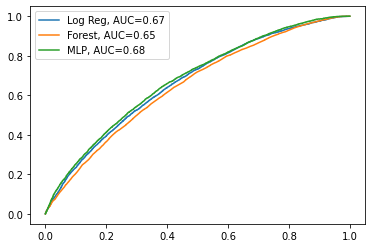

In [217]:
#set up plotting area
plt.figure(0).clf()

fpr, tpr, thresholds = metrics.roc_curve(y_test,prob_list_log)
auc = round(metrics.roc_auc_score(y_test,prob_list_log), 2)
plt.plot(fpr, tpr,label="Log Reg, AUC="+str(auc))        

fpr, tpr, thresholds = metrics.roc_curve(y_test,prob_list_forest)
auc = round(metrics.roc_auc_score(y_test,prob_list_forest), 2)
plt.plot(fpr, tpr,label="Forest, AUC="+str(auc)) 

fpr, tpr, thresholds = metrics.roc_curve(y_test,prob_list_mpl)
auc = round(metrics.roc_auc_score(y_test,prob_list_mpl), 2)
plt.plot(fpr, tpr,label="MLP, AUC="+str(auc)) 

#add legend
plt.legend();

In [218]:
#MPL classifier shows best results